In [108]:
from Scripts import ECG_processing
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import optimize
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


from sklearn.preprocessing import MultiLabelBinarizer
%load_ext autoreload
%autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SNOMED_scored=pd.read_csv("Data/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("Data/SNOMED_mappings_unscored.csv", sep=";")

In [3]:
ecg_data = pd.read_csv('Data/ecg_data_with_labels.csv')
ecg_data.shape

(42720, 114)

### Look for NaN and inf-values in dataset

In [4]:
print(np.where(ecg_data.iloc[:,:-1].isna()))
print(ecg_data.index[np.isinf(ecg_data.iloc[:,:-1]).any(1)])
#print(ecg_data.columns.to_series()[np.isinf(ecg_data.iloc[:,:-1]).any()])

(array([   10,    10,    10, ..., 42715, 42715, 42715], dtype=int64), array([ 86,  87,  90, ...,  86, 103, 108], dtype=int64))
Int64Index([  632,  3697,  3939,  4014,  4518,  5058,  5679,  5891,  6062,
             8216, 13699, 13724, 19728, 20086, 23641, 23989, 24402, 26278,
            27813, 28736, 29211, 29417, 29893, 32200, 34761, 36265, 37771,
            38037, 38738, 38760, 38789, 38790, 38793, 40416, 42518, 42715],
           dtype='int64')


In [5]:
ecg_data = ecg_data.dropna()

In [6]:
print(ecg_data.shape)
print(np.where(ecg_data.iloc[:,1:-1].isna()))
print(ecg_data.index[np.isinf(ecg_data.iloc[:,1:-1]).any(1)])
#print(data.columns.to_series()[np.isinf(data.iloc[:,1:-1]).any()])

(42574, 114)
(array([], dtype=int64), array([], dtype=int64))
Int64Index([], dtype='int64')


In [7]:
y_data = ecg_data['labels']

In [8]:
X_data = ecg_data.iloc[:,1:-1]

In [9]:
df_y = ECG_processing.make_class_with_unscored_labels(y_data,SNOMED_unscored)

In [10]:
one_hot = MultiLabelBinarizer()
y=one_hot.fit_transform(df_y['labels'].str.split(pat=','))
print(one_hot.classes_)
print("classes: {}".format(y.shape[1]))

['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'unscored class']
classes: 28


In [11]:
y = np.delete(y, -1, axis=1)

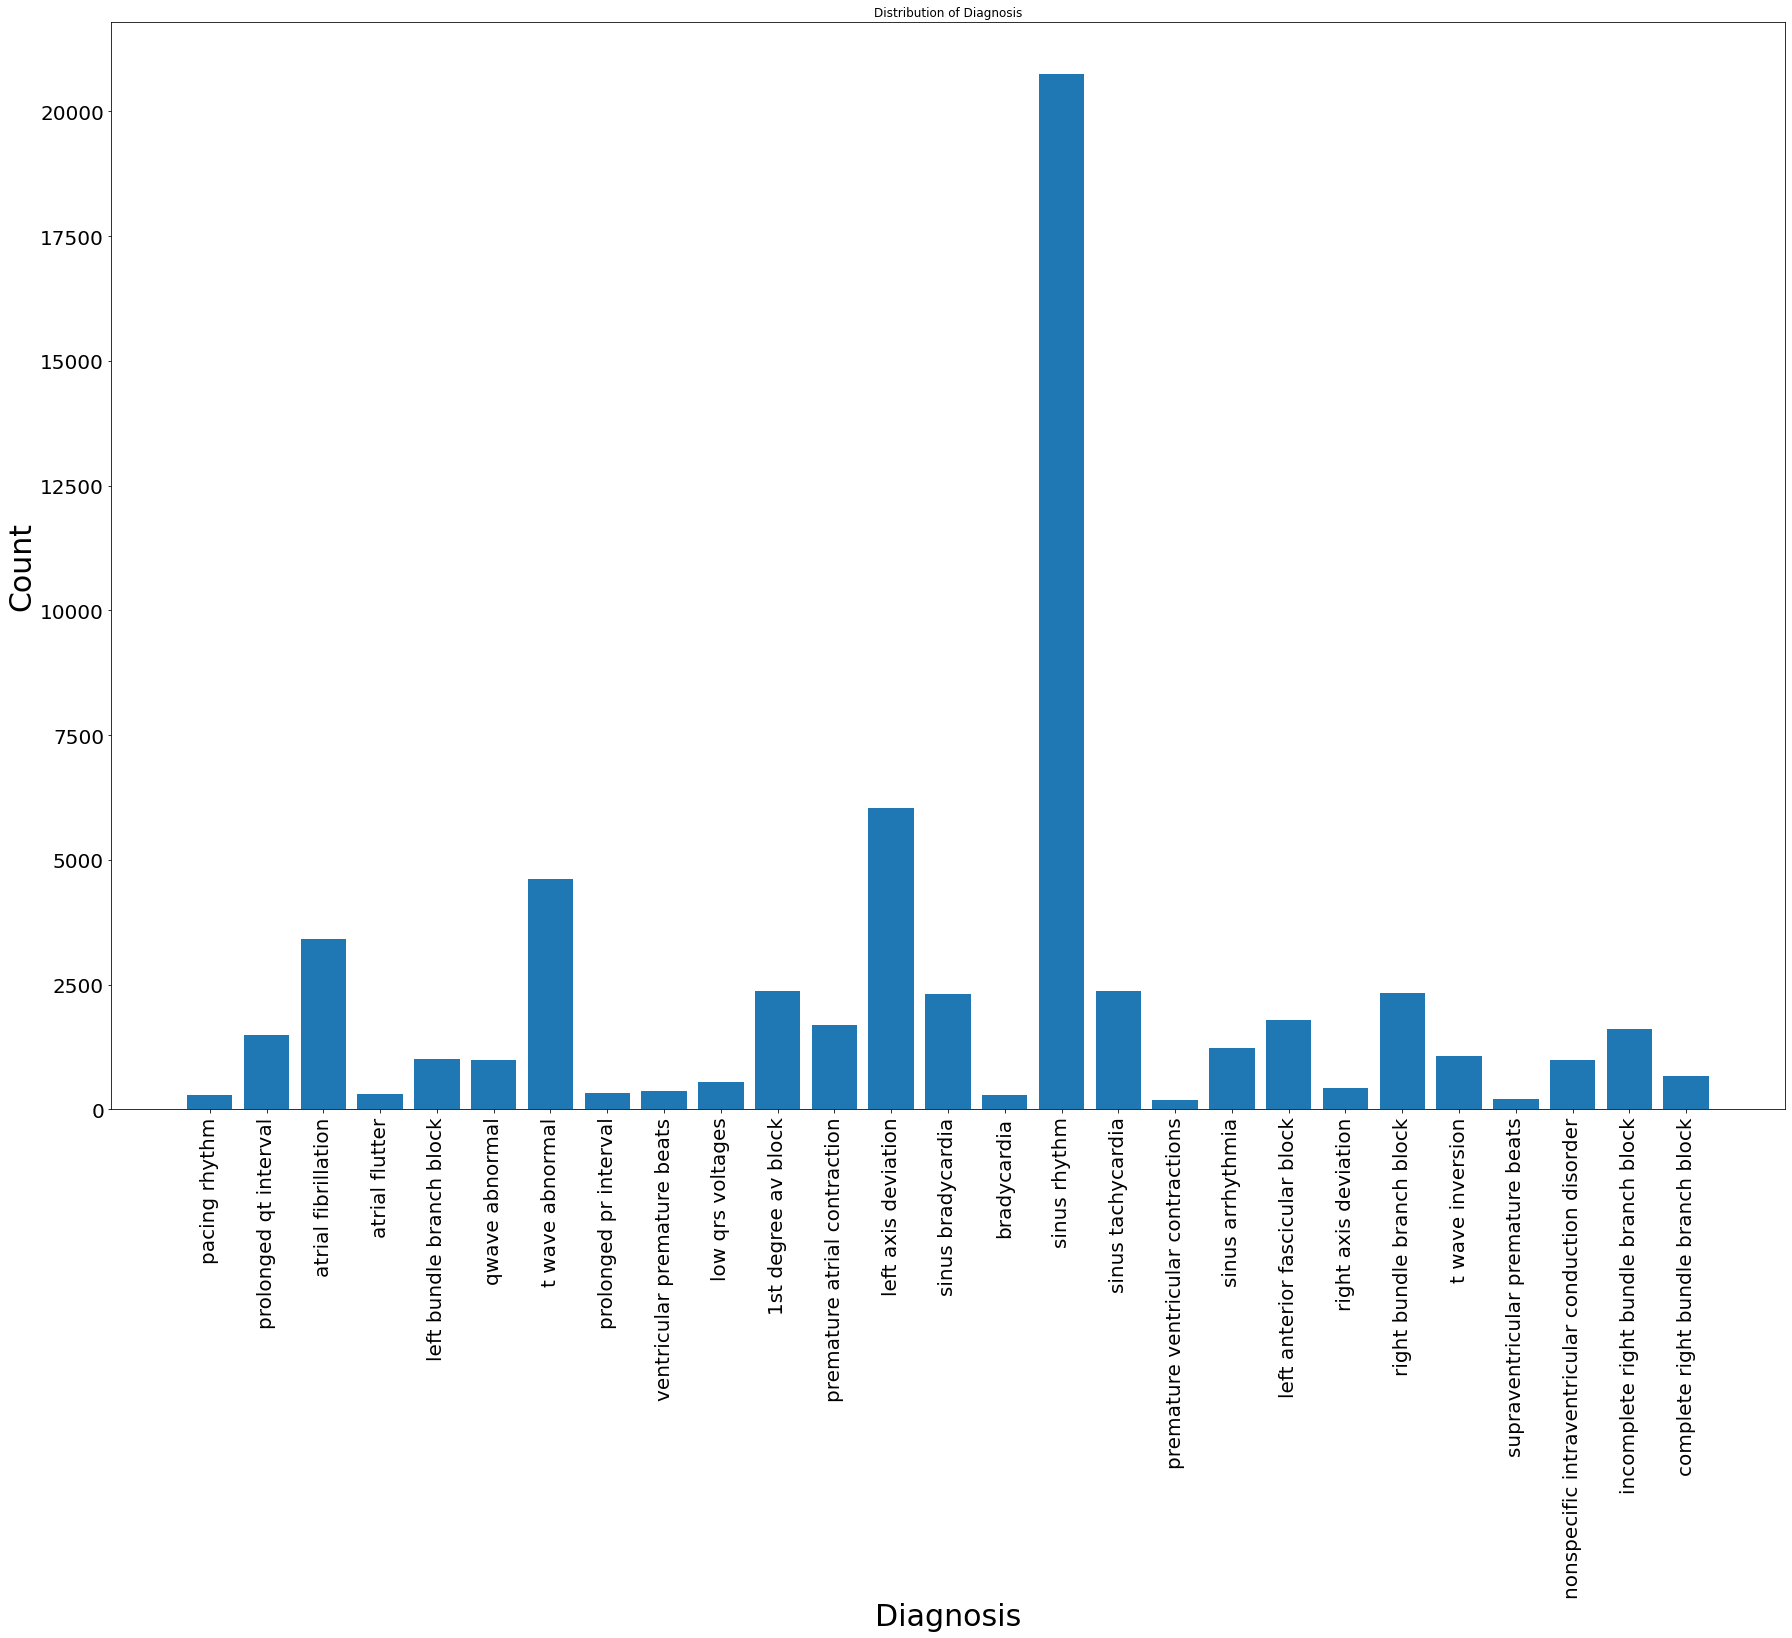

In [12]:
ECG_processing.plot_classes(one_hot.classes_[0:-1],y,SNOMED_scored)

In [13]:
X_train,y_train,X_test,y_test = ECG_processing.train_test_split_unbalanced_data(X_data,y,110)

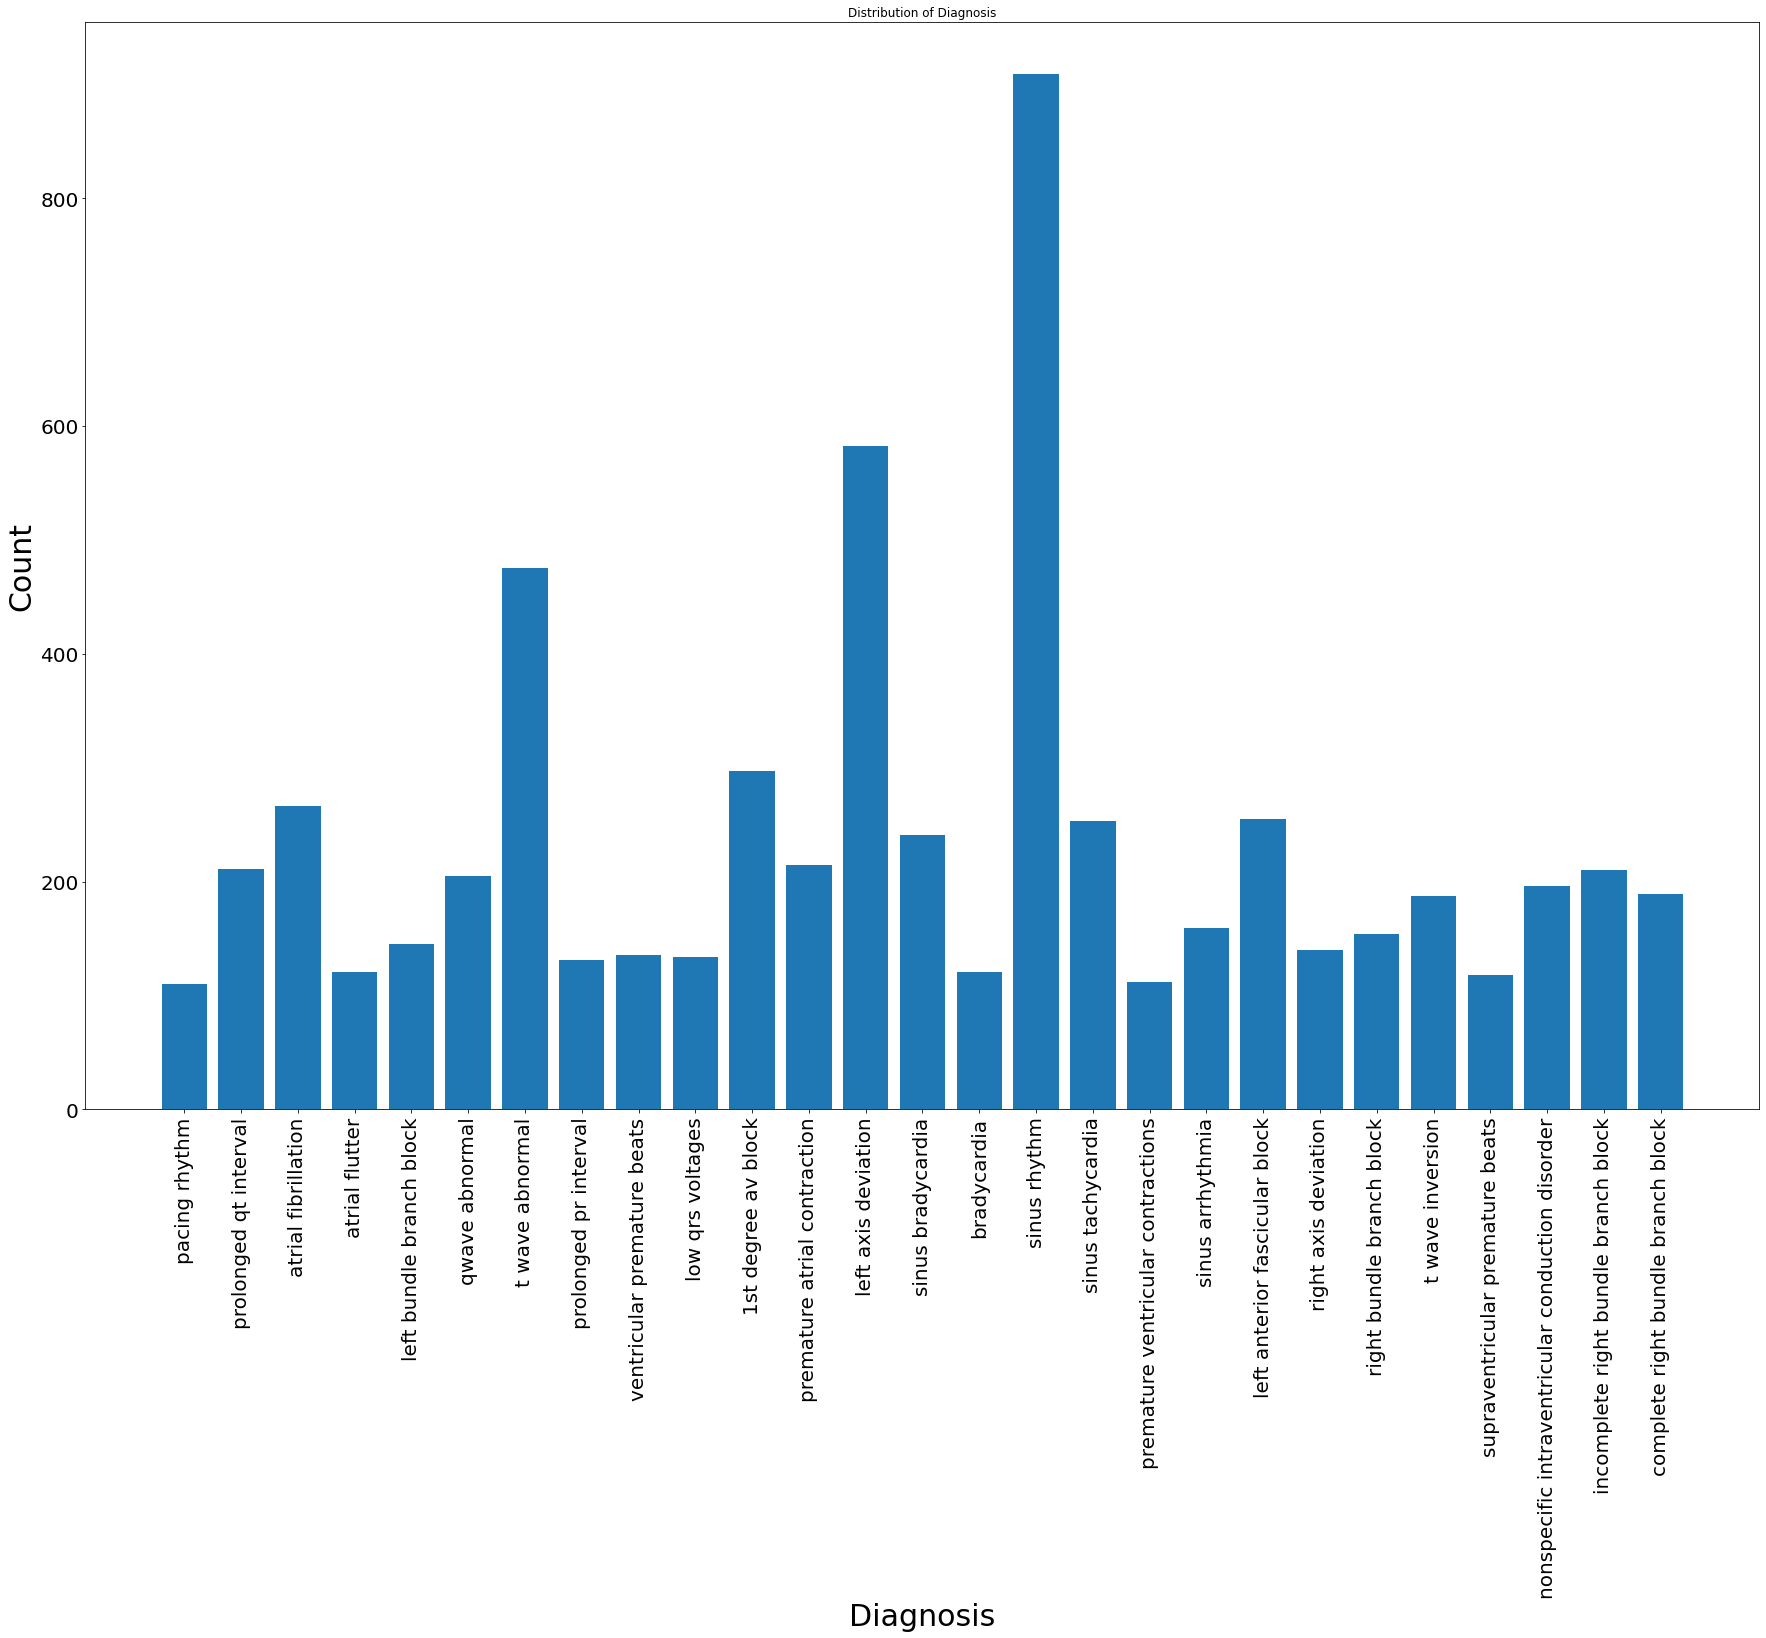

In [14]:
ECG_processing.plot_classes(one_hot.classes_[0:-1],y_test,SNOMED_scored,plt_name="distribution_test_data")

In [15]:
X_train.shape[1]

112

In [109]:
model = ECG_processing.NN_ECG(X_train.shape[1],y_train.shape[1], n_units=500)

In [110]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='categorical_accuracy', factor=0.1, patience=2, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', mode='max', verbose=1, patience=10)


In [111]:
model.fit(X_train,y_train, epochs=50, batch_size=256, callbacks = [reduce_lr,early_stop])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
156/156 [==============================] - 4s 24ms/step - loss: 4.5021 - categorical_accuracy: 0.2149
Epoch 2/50
156/156 [==============================] - 4s 24ms/step - loss: 0.4369 - categorical_accuracy: 0.3202
Epoch 3/50
156/156 [==============================] - 4s 25ms/step - loss: 0.2085 - categorical_accuracy: 0.3587
Epoch 4/50
156/156 [===================

In [112]:
y_pred_train = model.predict(X_train)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [116]:
highest_chall_metric = 0
best_thr = 0
for i in np.linspace(0,1,21):
    chall_metric =  ECG_processing.compute_challenge_metric_for_opt(y_train,(y_pred_train>(np.ones(y_train.shape[1])*i)))
    if chall_metric > highest_chall_metric:
        highest_chall_metric = chall_metric
        best_thr = np.ones(y_train.shape[1])*i

In [129]:
ECG_processing.compute_challenge_metric_for_opt(y_train,(y_pred_train>best_thr))

0.3638346120316231

In [118]:
new_best_thr = optimize.fmin(ECG_processing.thr_chall_metrics, args=(y_train,y_pred_train), x0=best_thr, maxiter=10)

In [130]:
ECG_processing.compute_challenge_metric_for_opt(y_train,(y_pred_train>new_best_thr))

0.3659915610341327

In [131]:
y_pred = model.predict(X_test)

In [132]:
ECG_processing.compute_challenge_metric_for_opt(y_test,(y_pred>new_best_thr))

0.42290188537794476

In [121]:
print("Accuracy:", accuracy_score(y_test,(y_pred>new_best_thr)))
print("F1-score:", f1_score(y_test,(y_pred>new_best_thr), average='macro'))
print("F2-score:", fbeta_score(y_test,(y_pred>new_best_thr), average='macro', beta=2))
print("G2-score:", ECG_processing.compute_beta_measures(y_test,(y_pred>new_best_thr), beta=2)[1])

Accuracy: 0.04594878989828131
F1-score: 0.27230449308655935
F2-score: 0.3167537860799386
G2-score: 0.13714541543060366


In [122]:
conf_matrix = ECG_processing.compute_modified_confusion_matrix_nonorm(y_test,(y_pred>new_best_thr))

In [123]:
norm_conf_matrix = np.zeros((conf_matrix.shape[0], conf_matrix.shape[1]))

In [124]:
for i in range(conf_matrix.shape[0]):
    norm_conf_matrix[i]=conf_matrix[i]/conf_matrix[i].sum()

In [125]:
df_conf_matrix = pd.DataFrame(norm_conf_matrix, columns=one_hot.classes_[:-1], index = one_hot.classes_[:-1])
df_conf_matrix.index.name = 'y_true'
df_conf_matrix.columns.name = 'y_pred'

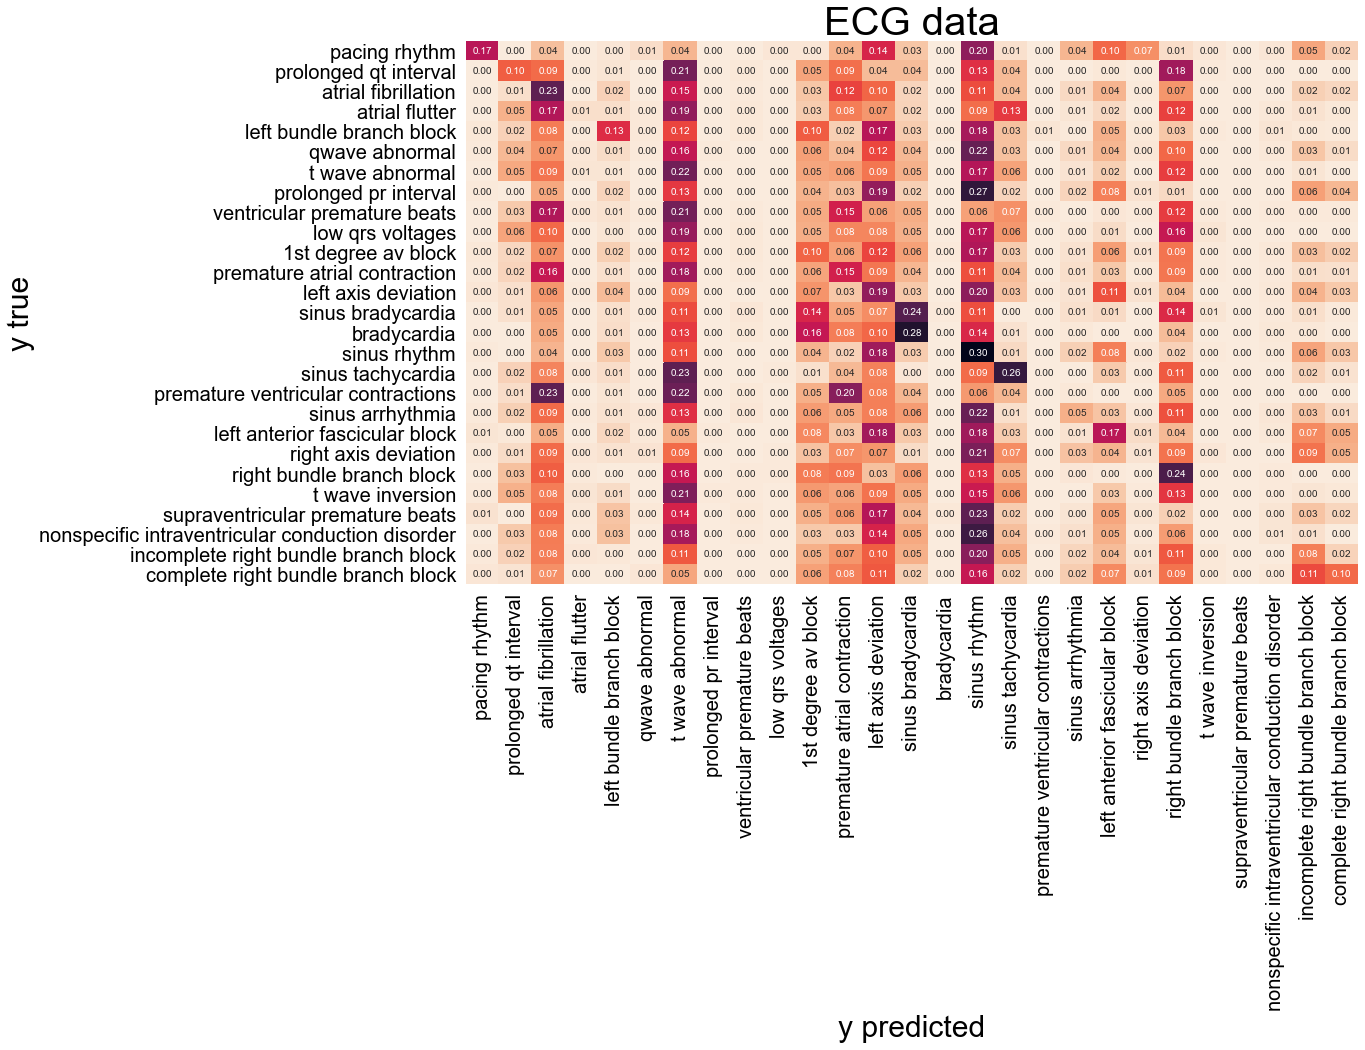

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (16,10))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_conf_matrix, cmap="rocket_r", annot=True,annot_kws={"size": 10}, fmt=".2f", cbar=False)
plt.title("ECG data", fontsize = 40, color= "black")
plt.xlabel("y predicted",fontsize=30, color= "black")
plt.ylabel("y true",fontsize = 30, color= "black")
plt.yticks(fontsize=20, rotation=0, color= "black")
plt.xticks(fontsize=20, rotation=90, color= "black")
plt.show()

In [74]:
conf_weights = pd.read_csv("Data/weights.csv", sep=",", header= 0, index_col=0 )

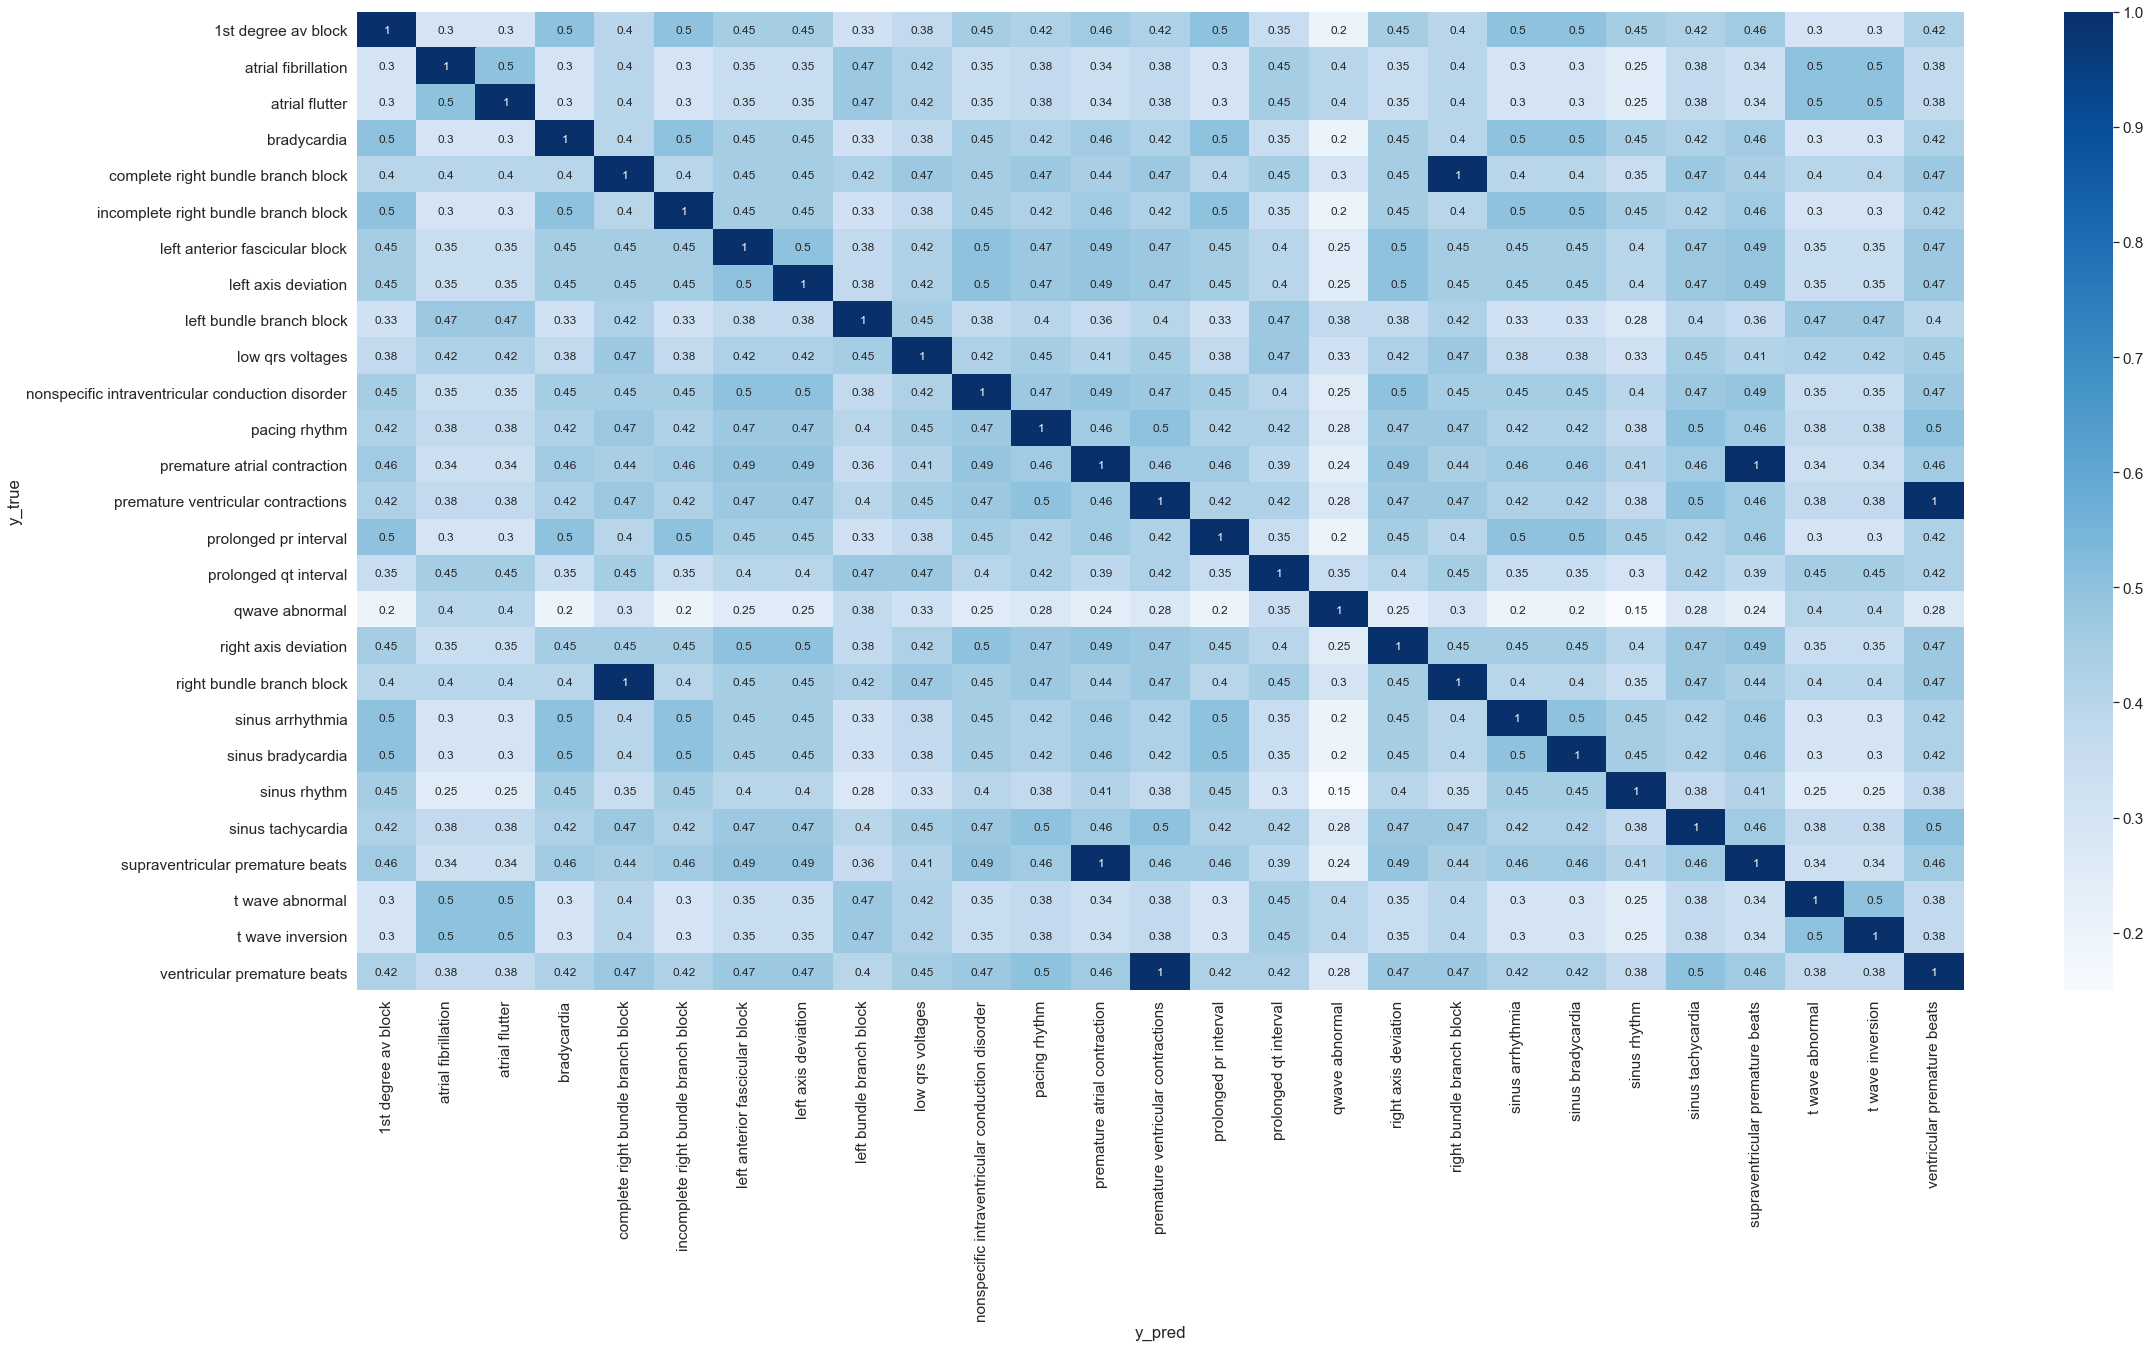

In [76]:
conf_weights.columns = SNOMED_scored.iloc[:,0]
conf_weights.index = SNOMED_scored.iloc[:,0]
conf_weights = pd.DataFrame(conf_weights, columns=SNOMED_scored.iloc[:,0], index = SNOMED_scored.iloc[:,0])

conf_weights.index.name = 'y_true'
conf_weights.columns.name = 'y_pred'

plt.figure(figsize = (36,18))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_weights, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
plt.savefig("Results/ECG_results/confmatrix_weights.png",dpi=100)

In [77]:
training_weights=ECG_processing.calculating_class_weights(y_train)

C:\Users\Bjorn\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Bjorn\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 0 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Bjorn\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[0 1 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Bjorn\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0.0, 1.0], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 pas

In [79]:
weight_dict = dict(zip(np.arange(y_train.shape[1]), training_weights.T[1]))

In [80]:
model = ECG_processing.NN_ECG(X_train.shape[1],y_train.shape[1], n_units=500)

In [81]:
model.fit(X_train,y_train, epochs=50, batch_size=256,class_weight=weight_dict)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
156/156 [==============================] - 4s 25ms/step - loss: 93.3875 - categorical_accuracy: 0.0809
Epoch 2/50
156/156 [==============================] - 4s 25ms/step - loss: 6.4370 - categorical_accuracy: 0.1351
Epoch 3/50
156/156 [==============================] - 4s 27ms/step - loss: 2.8101 - categorical_accuracy: 0.2235
Epoch 4/50
156/156 [==================

KeyboardInterrupt: 